In [0]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

---
# Model

In [0]:
def build_model(input_size=100, vocab_size=100, output_size=1):
    inputs = keras.Input((input_size,))
    x = layers.Embedding(vocab_size, 32)(inputs)
    
    x = layers.LSTM(64, activation="relu")(x)
    x = layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(vocab_size, activation="softmax")(x)
    
    return keras.Model(inputs, outputs)

In [0]:
model = build_model(input_size=20)

In [55]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 20)]              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 20, 32)            3200      
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                24832     
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               6500      
Total params: 38,692
Trainable params: 38,692
Non-trainable params: 0
_________________________________________________________________


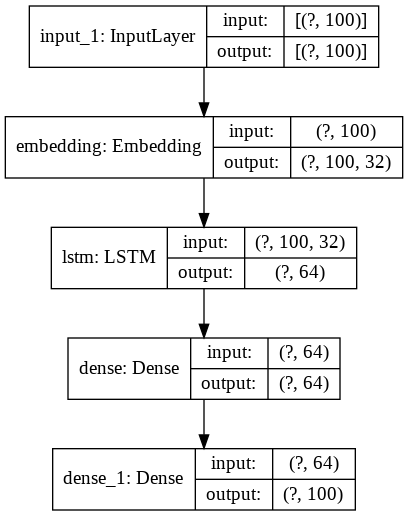

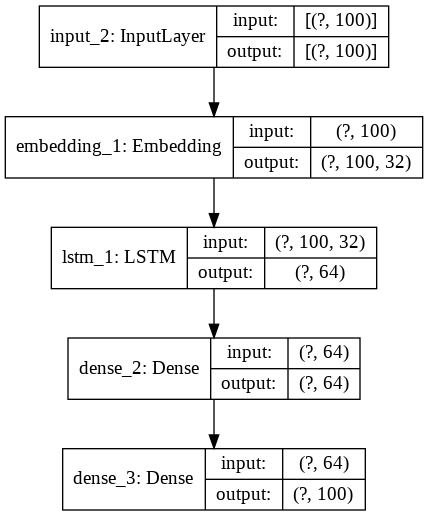

In [10]:
keras.utils.plot_model(model, show_shapes=True)

---
# Data

In [0]:
import tensorflow_datasets as tfds
from tensorflow_datasets.text import imdb

import string
import numpy as np

In [0]:
reviews = imdb.IMDBReviews(config="plain_text")

In [0]:
reviews.download_and_prepare()

In [0]:
datasets = reviews.as_dataset()
rev_train, rev_test = datasets["train"], datasets["test"]

---
## Preprocessing

In [0]:
clean_chars = set(string.printable)

char_to_idx = {c: i for i, c in enumerate(sorted(clean_chars))}
idx_to_char = {i: c for i, c in enumerate(sorted(clean_chars))}

In [0]:
def clean(s):
    return "".join(c for c in s if c in clean_chars)

def make_seq(s, length=100, skip=1):
    return [s[i:i + length] for i in range(0, len(s) - length, skip)]

In [0]:
def seq_generator(dataset, seq_length=100, seq_skip=5):
    for sample in tfds.as_numpy(rev_test):
        text = clean(sample["text"].decode())
        for seq in make_seq(text, seq_length, seq_skip):
            yield seq
            
def sample_generator(dataset, seq_length=100, seq_skip=5, predict_length=1):
    for seq in seq_generator(dataset, seq_length + predict_length, seq_skip):
        yield seq[:seq_length], seq[seq_length:]
        
def sample_idx_generator(dataset, c2i, seq_length=100, seq_skip=5, predict_length=1):
    for text, label in sample_generator(dataset, seq_length, seq_skip, predict_length):
        yield [c2i[c] for c in text], [c2i[c] for c in label]

def batch_generator(dataset, c2i, batch_size=32, seq_length=100, seq_skip=5, predict_length=1):
    num_classes = max(c2i.values()) + 1
    
    batch_x = []
    batch_y = []
    i = 0
    for text, label in sample_idx_generator(rev_train, char_to_idx, seq_length, seq_skip, predict_length):
        if i < batch_size:
            batch_x.append(text)
            batch_y.append(keras.utils.to_categorical(label[0], num_classes)) #todo: remove [0] and make model work with many outputs
            i += 1
        else:
            yield np.array(batch_x), np.array(batch_y)
            batch_x = []
            batch_y = []
            i = 0
        

In [0]:
for i, seq in enumerate(batch_generator(rev_train, char_to_idx)):
    if i > 100:
        break
        
    print(i, seq[0], seq[0].shape, seq[1], seq[1].shape, sep="\n")

---
# Training

In [0]:
data_gen = batch_generator(rev_train, char_to_idx, seq_length=20)

In [0]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [73]:
history = model.fit_generator(data_gen, steps_per_epoch=1000, epochs=10)

  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 1000 steps
Epoch 1/10
1000/1000 [==============================] - 21s 21ms/step - loss: 1.8751 - accuracy: 0.4572
Epoch 2/10
1000/1000 [==============================] - 21s 21ms/step - loss: 1.8913 - accuracy: 0.4570
Epoch 3/10
1000/1000 [==============================] - 21s 21ms/step - loss: 1.8634 - accuracy: 0.4583
Epoch 4/10
1000/1000 [==============================] - 21s 21ms/step - loss: 1.8595 - accuracy: 0.4614
Epoch 5/10
1000/1000 [==============================] - 21s 21ms/step - loss: 1.8437 - accuracy: 0.4623
Epoch 6/10
1000/1000 [==============================] - 21s 21ms/step - loss: 1.8360 - accuracy: 0.4673
Epoch 7/10
1000/1000 [==============================] - 21s 21ms/step - loss: 1.8235 - accuracy: 0.4694
Epoch 8/10
1000/1000 [==============================] - 21s 21ms/step - loss: 1.8068 - accuracy: 0.4768
Epoch 9/10
1000/1000 [==============================] - 21s 21ms/step - loss: 1.8228 - accuracy: 0.4724
Epoch 10/10
1000/1000 [====================

---
# Test

In [0]:
def pad(s, length, char=" "):
    if len(s) >= length:
        return s
    
    return char * (length - len(s)) + s

def to_seq(s):
    return [char_to_idx[c] for c in s]

def predict_char(model, input_str):
    seq = to_seq(pad(input_str, model.input_shape[-1]))
    return idx_to_char[model.predict([seq]).argmax()]

In [62]:
predict_char(model, "hello w")

'i'

In [59]:
res = model.predict(np.random.randint(100, size=(1, 20))).flatten()
sort = res.argsort()[::-1]
print(*list(zip(map(idx_to_char.__getitem__, sort), res[sort])), sep="\n")

('b', 0.9920223)
('.', 0.0065001044)
('r', 0.00039110368)
('T', 0.00032120926)
('I', 0.00017737472)
('W', 0.00015793798)
('B', 0.00011611051)
('A', 8.056089e-05)
('<', 7.867624e-05)
('t', 5.414517e-05)
('N', 1.9678497e-05)
('n', 1.6067648e-05)
('S', 1.3247881e-05)
('F', 1.302474e-05)
('w', 6.32605e-06)
('D', 5.5755954e-06)
('O', 4.666477e-06)
('/', 4.306724e-06)
('M', 4.0410105e-06)
('m', 3.5522219e-06)
('f', 2.6825576e-06)
('H', 1.3849295e-06)
(' ', 1.3292077e-06)
('s', 1.2283048e-06)
('o', 9.668781e-07)
('h', 4.511559e-07)
('u', 3.2740476e-07)
('R', 3.269723e-07)
('C', 2.9731555e-07)
('1', 2.2850543e-07)
('y', 2.1415879e-07)
('"', 1.5824274e-07)
('i', 1.4805401e-07)
('E', 5.083385e-08)
('L', 4.1380478e-08)
('a', 3.649621e-08)
('l', 1.6181415e-08)
('v', 1.43062495e-08)
('c', 8.511018e-09)
('9', 8.29593e-09)
('p', 5.578597e-09)
('G', 5.2535674e-09)
('d', 4.5027857e-09)
('*', 2.1337185e-09)
('Y', 5.422533e-10)
('3', 1.9566615e-10)
('(', 1.2875544e-10)
('g', 1.0670048e-10)
('>', 4.933015

In [0]:
def gen_next_n(model, n, seed):
  s = seed
  for _ in range(n):
    s += predict_char(model, s[-model.input_shape[-1]:])

  return s

In [76]:
# Keeps predicting "the story " 
gen_next_n(model, 100, "The blue ant")

'The blue ant the story the story the story the story the story the story the story the story the story the story'